In [16]:
import aiida
from aiida import orm, load_profile
from aiida.orm import StructureData
import sys, os
from aiida.orm.utils import load_entity, load_code, load_computer, load_group, load_node
from collections import Counter
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from aiida.orm import QueryBuilder

from collections import Counter
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
import ase
from ase.io import read, write
from ase.atoms import Atoms
from ase.calculators import calculator
from ase.calculators.calculator import Calculator, kpts2ndarray
from ase import Atoms
from operator import itemgetter
from ase.calculators.abinit import Abinit

# Librascal
from rascal.representations import SphericalInvariants as SOAP

sys.path.append('./kernel-tutorials/')
# Local Utilities for Notebook
from utilities.general import FPS, center_matrix, normalize_matrix, load_variables
from utilities.kernels import linear_kernel, gaussian_kernel, center_kernel
from utilities.general import load_variables, get_stats
from utilities.plotting import (
    plot_base, 
    plot_projection,
    plot_regression,
    plot_simple,
    get_cmaps,
    table_from_dict,
    check_mirrors,
)
from utilities.general import FPS, center_matrix, normalize_matrix, load_variables
from utilities.kernels import linear_kernel, gaussian_kernel, center_kernel
cmaps = get_cmaps()
plt.style.use("./kernel-tutorials/utilities/kernel_pcovr.mplstyle")
dbl_fig = (2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])

#skcosmo

from skcosmo.preprocessing import SparseKernelCenterer as SKC
from skcosmo.decomposition import PCovR
import random

from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from chemiscope import write_input
import json
from cur import cur_decomposition
from numpy.linalg import pinv as inv

In [2]:
#dataset load
len_dataset=79855
load_profile('Elena')
qb = QueryBuilder()
qb.append(orm.StructureData)

In [3]:
select=100
qb_red=random.sample(qb.all(), select)
frames_ase=[]
for [structure_data] in qb_red:
    frame=structure_data.get_ase()
    frame.wrap()
    frames_ase.append(frame)
# array1 = np.random.randint(0,len_dataset-1, size=len_dataset)
# len(array1)
# masked = (qb.all()[array1] > int(len_dataset-(len_dataset-select)))
# # print(type(masked))


In [4]:
def frames(x):
    for [structure_data] in x:
        frame=structure_data.get_ase()
        frame.wrap(eps=1e-11)
        yield frame
def atomic_numbers(x):
    for [structure_data] in x:
        frame=structure_data.get_ase()
        mass=frame.get_atomic_numbers()
        yield mass
def natoms(x):
    for [structure_data] in x:
        natom = len(structure_data.get_site_kindnames())
        yield natom
def volumes(x):
    for [structure_data] in x:
        frame=structure_data.get_ase()
        vol=frame.get_volume()
        yield vol
 

In [5]:
# Compute SOAPs (from librascal tutorial)
# soap = SOAP(soap_type='PowerSpectrum',
#            interaction_cutoff=3.5,
#            max_radial=6,
#            max_angular=6,
#            gaussian_sigma_type='Constant',
#            gaussian_sigma_constant=0.4,
#            cutoff_smooth_width=0.5)

soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)

soap_rep = soap.transform(frames(qb_red))


In [6]:
X_raw = soap_rep.get_features(soap)

num_features = X_raw.shape[1]

"""Checking how many rows with all 0.0 entries are there"""
p = np.where(X_raw != 0)
type(p)
X_raw_new = X_raw[min(p[0]) : max(p[0]) + 1, min(p[1]) : max(p[1]) + 1]
print('There are '+str(X_raw.shape[0]-X_raw_new.shape[0])+' rows with all zero entries that are slowing down the calculation and do not contribute to SOAP vector')

There are 0 rows with all zero entries that are slowing down the calculation and do not contribute to SOAP vector


In [7]:
"""CUR decomposition:matrix approximation of a matrix A in matrices C, U, and R such that:
    C is made from columns of A, 
    R is made from rows of A, 
    the product CUR closely approximates A."""

def decision(probability):
    return random.random() < probability
def colselect(A, k , row = False , eps =1):
    c = ( k*np.log(k))/(eps*eps)
    m, n = A.shape[0], A.shape[1]
    u, s, vh = np.linalg.svd(A,full_matrices= False )
    vh = vh[:k,:]
    probs = (1/ k)*(vh**2).sum(axis =0)
    probs = [min(1,c*p) for p in probs]
    idxs = [decision(p) for p in probs]
    cols= A[:,idxs]
    included_idx= [i for i in range(n) if idxs[i]]
    if row :    
        return cols.T, included_idx
    return cols, included_idx

def cur_decompose (A,k,e=1, return_idx = False ) :
    m, n = A.shape[ 0 ] , A.shape[ 1 ]
    if k>min (m, n) :
        return [ ] , [ ] , [ ]
    C, included_cols = colselect (A, k , False , eps=e )
    R, included_rows = colselect(A.T, k , True , eps=e )
    U = inv(C) @ A @ inv(R)
    if return_ixd:
        return C,U,R, included_cols, included_rows
    return C,U,R

def  give_cur_vals(A, k, N=10):
    c,u,r,cols,rows = cur_decompose(A,k,return_idx=True)
    err=give_error(A, c@u@r)
    for i in range (N):
        ctmp, utmp, rtmp ,c_tmp, r_tmp=cur_decompose(A, k, return_idx=True)
        err_temp=give_error(A, ctmp@utmp@rtmp)
        if err_temp<err:
            err=err_temp
            c=ctmp
            u=utmp
            r=rtmp
            cols=c_tmp
            rows=r_tmp
    return c,u,r,err,cols, rows
def give_cur_results(A, upto=10):
    erros=[]
    ks=[i for i in range(1, upto+1)]
    for k in ks:
        a,b,c,err,rows, cols= give_cur_vals(A,k)
        errors.append(err)
    return errors 

def plot_cur_error(A, upto =10):
    errs= give_cur_results (A, upto)
    x = [ i for i in range ( 1 , upto +1)]
    plt.plot(x , errs,'r-')
    plt.show() 

In [8]:
"""First methos with conda package"""

r = 100
C_cur, U, R = cur_decomposition (X_raw, r)
X_raw.shape, C_cur.shape, U.shape, R.shape

# """Second method from definitions in cell above"""

# plot_cur_error(X_raw, upto=10)


((3749, 94500), (3749, 100), (100, 100), (100, 94500))

In [9]:
# FPS the components
print(f"Each SOAP vector contains {num_features} components.\
       \nWe use furthest point sampling to generate a subsample of our SOAP vectors.")

n_FPS=100
col_idxs, col_dist = FPS(X_raw.T, n_FPS)
X_FPS = X_raw[:, col_idxs]
X_FPS.shape

Each SOAP vector contains 94500 components.       
We use furthest point sampling to generate a subsample of our SOAP vectors.


(3749, 100)

In [10]:
# properties=['masses', 'masses']
# Y = np.vstack([np.concatenate([frame.arrays[property] for frame in frames_ase]) for property in properties]).T
l=np.concatenate(frames_ase)
len(l)
Y=np.zeros((len(l), 1))

natoms_list=[]
start=0
for frame in frames_ase:
    natoms=(len(frame))
#     Y[start:int(start+natoms), 0] = int(natoms)
    if natoms%4==0:
        Y[start:int(start+natoms)] = int(2)
    else:
        Y[start:int(start+natoms)] = int(1)
    start=start+natoms
Y.shape


(3749, 1)

In [11]:
# Splits in train and test sets
X1=np.copy(X_FPS)
X2=np.copy(C_cur)

n_train = int(len(Y)/2)
n_test = len(Y)-n_train
r_train = np.asarray(range(len(Y)))
np.random.shuffle(r_train)
i_test = list(sorted(r_train[n_train:]))
i_train = list(sorted(r_train[:n_train]))

X1_train = X1[i_train]
X2_train = X2[i_train]
Y_train = Y[i_train]
X1_test = X1[i_test]
X2_test = X2[i_test]
Y_test = Y[i_test]

print(f'Shape of testing FPS data is: {X1_train.shape}, ||X|| = {np.linalg.norm(X1_train)}.') 
print(f'Shape of testing CUR data is: {X2_train.shape}, ||X|| = {np.linalg.norm(X2_train)}.') 


Shape of testing FPS data is: (1874, 100), ||X|| = 30.191533841920826.
Shape of testing CUR data is: (1874, 100), ||X|| = 43.741605549825515.


In [12]:
X1_center = X1_train.mean(axis=0)
X2_center = X2_train.mean(axis=0)
# Y_center = Y_train.mean(axis=0)

# Center total dataset
X1 = center_matrix(X1, center=X1_center)
X2 = center_matrix(X2, center=X2_center)
# Y = center_matrix(Y, center=Y_center)

# Center training data
X1_train = center_matrix(X1_train, center=X1_center)
X2_train = center_matrix(X2_train, center=X2_center)
# Y_train = center_matrix(Y_train, center=Y_center)

# Center testing data
X1_test = center_matrix(X1_test, center=X1_center)
X2_test = center_matrix(X2_test, center=X2_center)
# Y_test = center_matrix(Y_test, center=Y_center)

# Calculate the scale of the training data
X1_scale = np.linalg.norm(X1_train) / np.sqrt(n_train)
X2_scale = np.linalg.norm(X2_train) / np.sqrt(n_train)
# Y_scale = np.linalg.norm(Y_train) / np.sqrt(n_train)

# Scale the total dataset
X1 = normalize_matrix(X1, scale=X1_scale)
X2 = normalize_matrix(X2, scale=X2_scale)
# Y = normalize_matrix(Y, scale=Y_scale)

# Scale the training data
X1_train = normalize_matrix(X1_train, scale=X1_scale)
X2_train = normalize_matrix(X2_train, scale=X2_scale)
# Y_train = normalize_matrix(Y_train, scale=Y_scale)

# Scale the testing data
X1_test = normalize_matrix(X1_test, scale=X1_scale)
X2_test = normalize_matrix(X2_test, scale=X2_scale)
# Y_test = normalize_matrix(Y_test, scale=Y_scale)

In [13]:
C1 = X1_train.T @ X1_train
C2 = X2_train.T @ X2_train


v_C1, U_C1 = np.linalg.eigh(C1)
v_C2, U_C2 = np.linalg.eigh(C2)


# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C1= np.flip(U_C1, axis=1)
v_C1= np.flip(v_C1, axis=0)

U_C2= np.flip(U_C2, axis=1)
v_C2= np.flip(v_C2, axis=0)

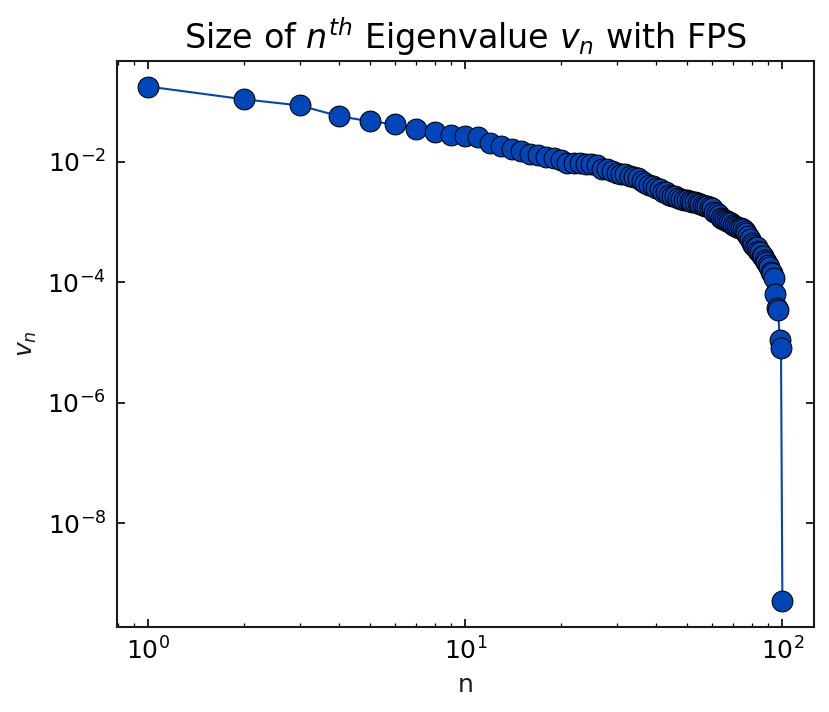

Text(0, 0.5, '$v_n$')

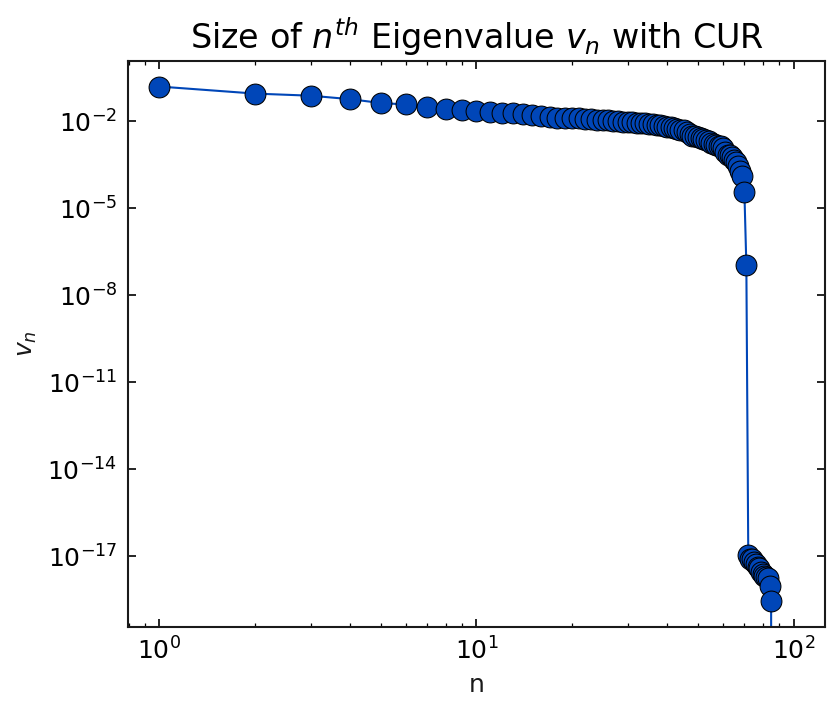

In [14]:
plt.loglog(np.asarray(range(len(v_C1))) + 1, v_C1 / n_train, marker="o")
plt.title(r"Size of $n^{th}$ Eigenvalue $v_n$ with FPS")
plt.xlabel("n")
plt.ylabel(r"$v_n$")
plt.show()
plt.close()
plt.loglog(np.asarray(range(len(v_C2))) + 1, v_C2 / n_train, marker="o")
plt.title(r"Size of $n^{th}$ Eigenvalue $v_n$ with CUR")
plt.xlabel("n")
plt.ylabel(r"$v_n$")

[[2.]
 [2.]
 [2.]
 ...
 [1.]
 [1.]
 [1.]]
(100, 100) (1874, 100) (1874, 100) (100, 100) (1874, 100) (1874, 100) (1874, 1)


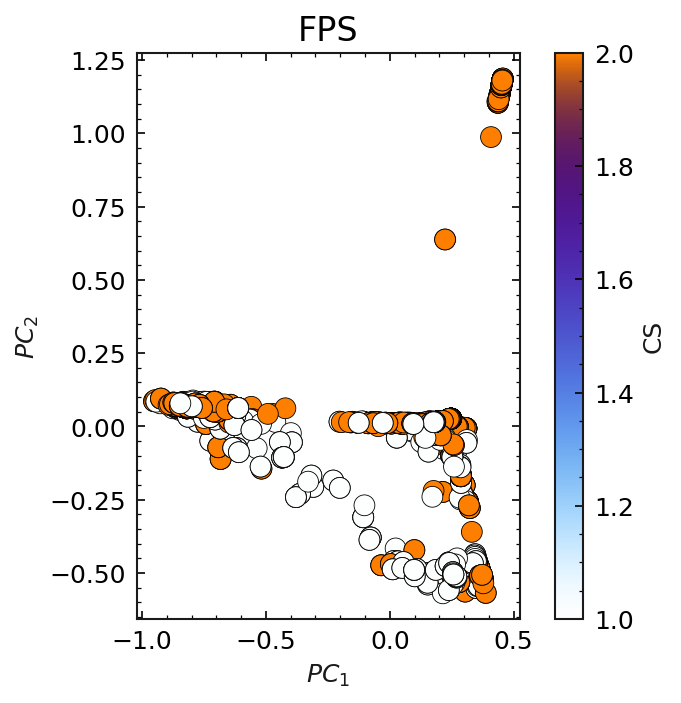

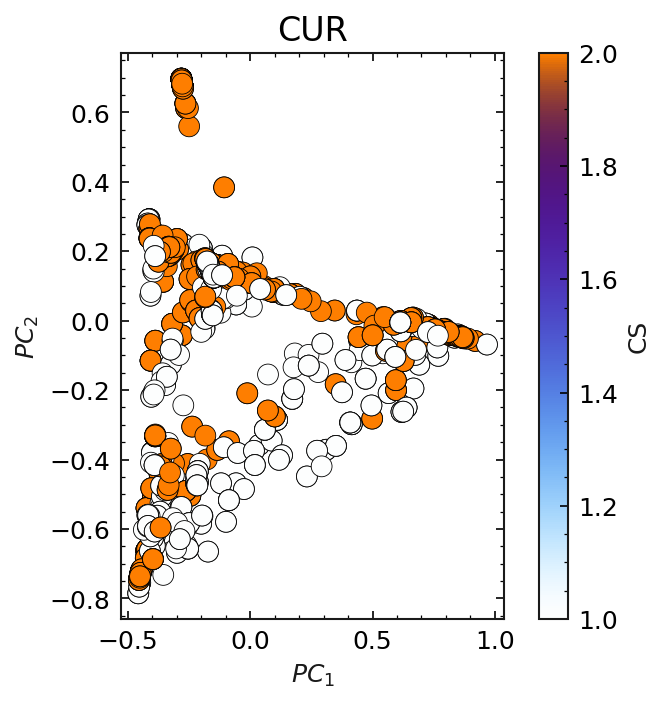

In [15]:
n_PC=100
PXT1 = U_C1[:, :n_PC]
PTX1 = PXT1.T

PXT2 = U_C2[:, :n_PC]
PTX2 = PXT2.T

print(Y_train)
T1 = X1_train @ PXT1
T2 = X2_train @ PXT2

print(PXT1.shape, X1_train.shape,  T1.shape,
      PXT2.shape, X2_train.shape,  T2.shape, Y_train.shape)

plot_projection(Y_train, T1, **cmaps, title='FPS')
plt.show()
plt.close()
plot_projection(Y_train, T2, **cmaps, title='CUR')

plt.savefig('PCA_tutorial_mixed_db.png', bbox_inches= 'tight', dpi=700)

<AxesSubplot:xlabel='$PC_1$', ylabel='$PC_2$'>

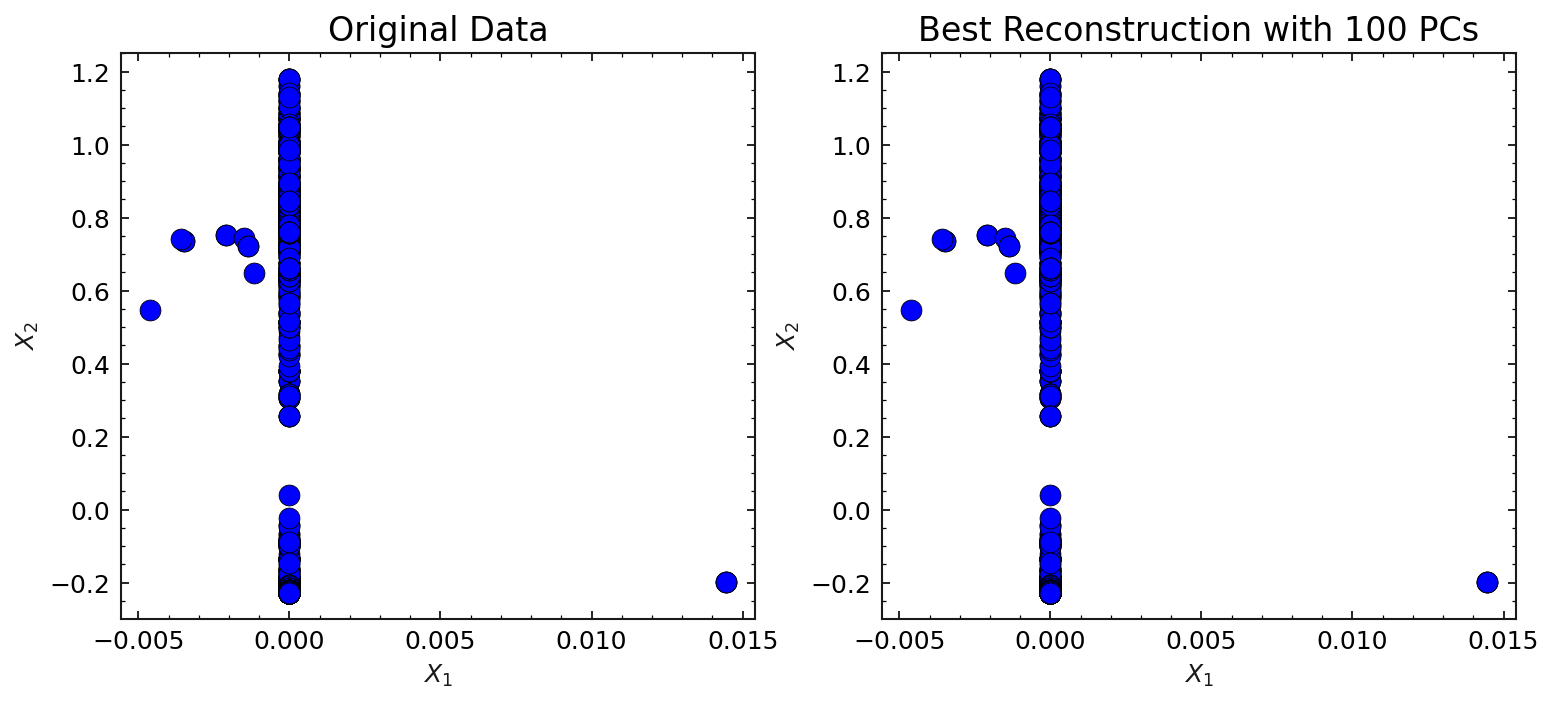

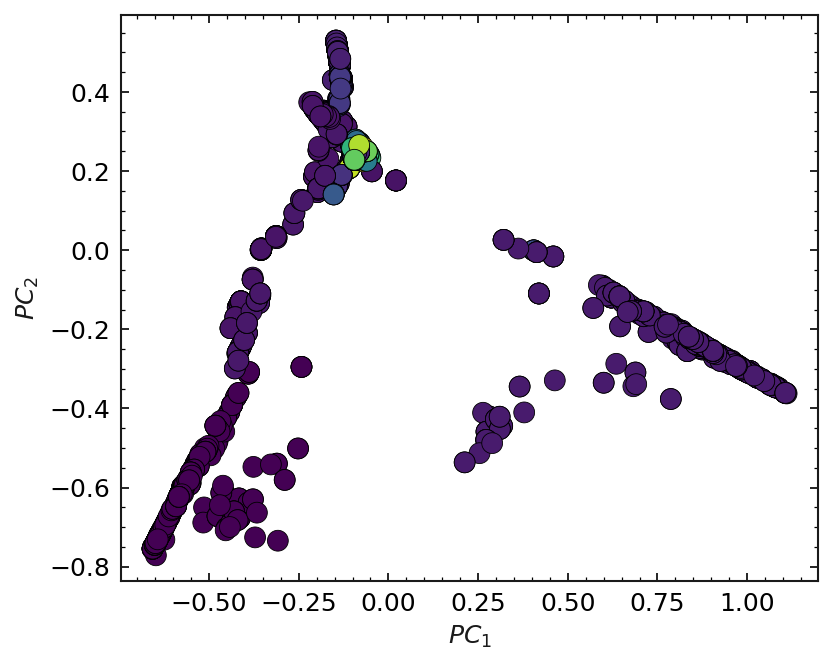

In [39]:
X_PCA = T @ PTX
fig, ax = plt.subplots(1, 2, figsize=dbl_fig)
plot_simple(X_train, fig=fig, ax=ax[0], title="Original Data", **cmaps)
plot_simple(
    X_PCA,
    fig=fig,
    ax=ax[1],
    title="Best Reconstruction with {} PCs".format(n_PC),
    **cmaps
)
T_PCA_test = X_test @ PXT
X_test_PCA = T_PCA_test @ PTX
plot_projection(Y_test, T_PCA_test, **cmaps)

In [18]:
table_from_dict([get_stats(x=X_train, y=Y_train, t=T, xr=X_PCA), 
                 get_stats(x=X_test, y=Y_test, t=T_PCA_test, xr=X_test_PCA)], 
                 headers = ["Training", "Testing"], 
                 title="PCA")

<center><b> PCA </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 1 </td><td> 0.997499 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 1 </td><td> 0.997499 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> -1.55431e-15 </td><td> -3.55271e-15 </td></tr><tr><td> $\ell_{proj}$ </td>                                                <td> 2.35338e-30 </td><td> 2.38102e-30 </td></tr></table></center>

Text(0, 0.5, 'Error')

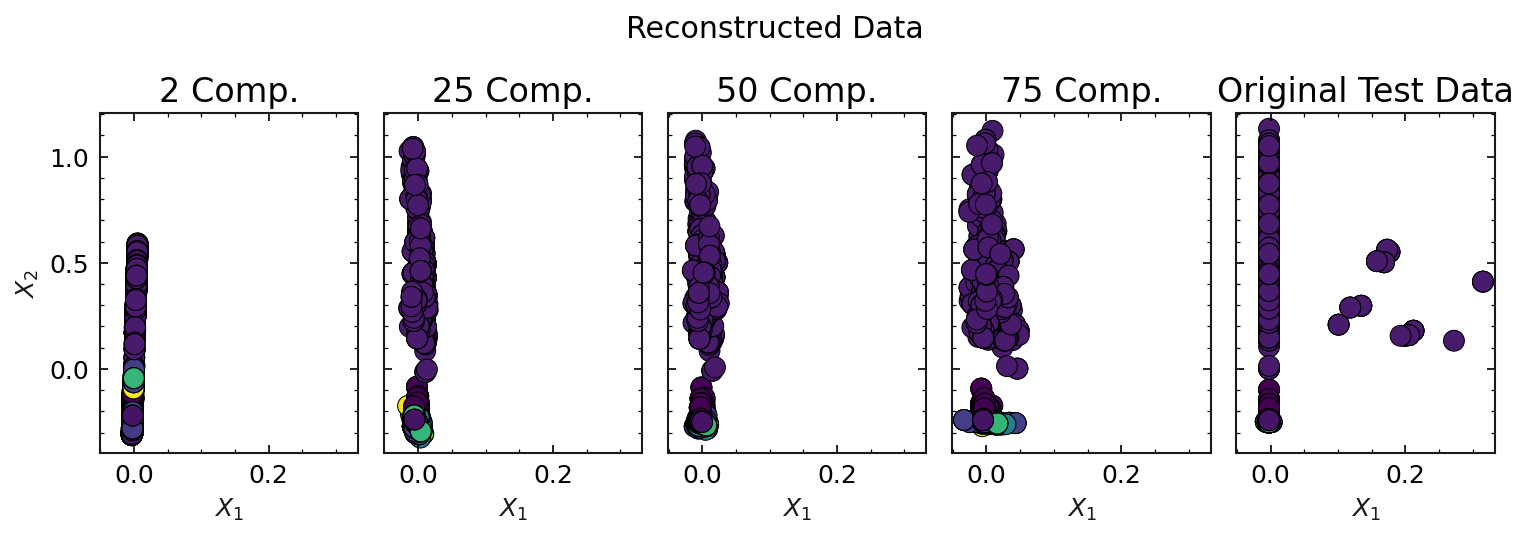

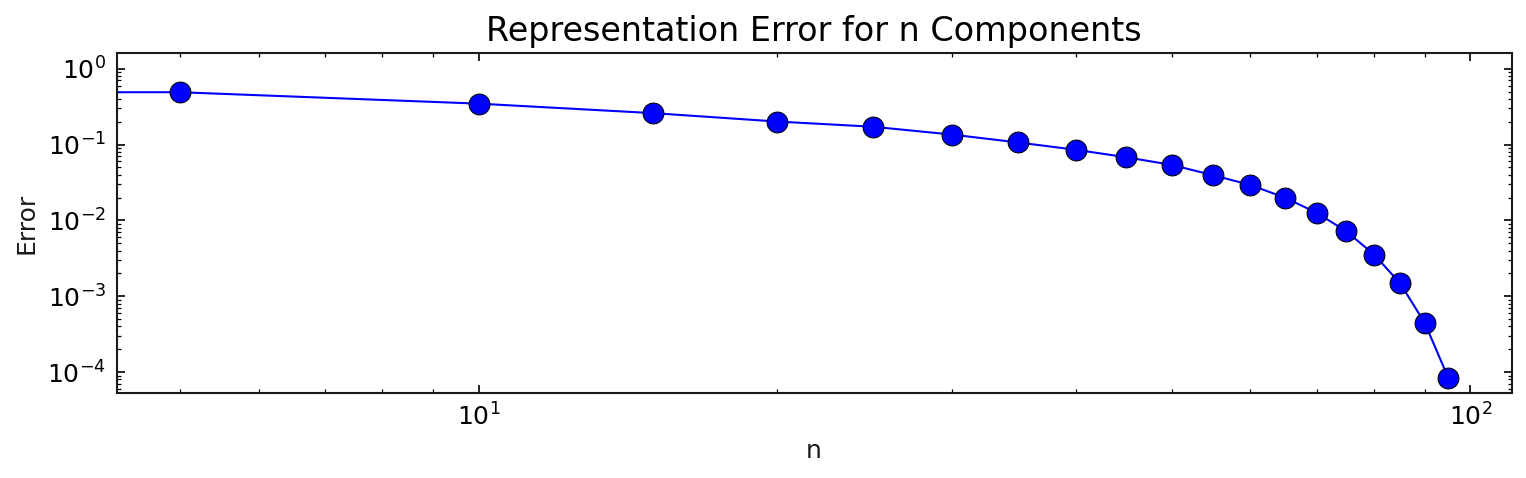

In [19]:
trials = range(X_test.shape[1])[::5]

n_plot = 4
fsize = (3 * n_plot, 3)

fig, ax = plt.subplots(1, n_plot + 1, figsize=fsize, sharex=True, sharey=True)

for i, n in enumerate(trials[:: int(len(trials) / n_plot)]):
    n = max(n, 2)
    PXT = U_C[:, :n]
    PTX = PXT.T

    X_r = X_test @ PXT @ PTX

    ax[i].scatter(X_r[:, 0], X_r[:, 1], c=Y_test[:, 0], linewidth=0.5, edgecolor="k")
    ax[i].set_title(f"{n} Comp.")
    ax[i].set_xlabel(r"$X_1$")

ax[-1].scatter(X_test[:, 0], X_test[:, 1], c=Y_test[:, 0], linewidth=0.5, edgecolor="k")
ax[-1].set_title("Original Test Data")
ax[-1].set_xlabel(r"$X_1$")
ax[0].set_ylabel(r"$X_2$")

fig.suptitle("Reconstructed Data", y=1.1)
fig.subplots_adjust(wspace=0.1)

plt.figure(figsize=fsize)
plt.loglog(
    trials,
    [
        ((X_test - X_test @ U_C[:, 0:n] @ U_C[:, :n].T) ** 2).mean(axis=0).sum()
        for n in trials
    ],
    "b-",
    marker="o",
)
plt.title(r"Representation Error for n Components")
plt.xlabel("n")
plt.ylabel("Error")

In [15]:
regularization = 1e-6

lr = Ridge(alpha=regularization)
lr.fit(X_train, Y_train)
Yhat_train = lr.predict(X_train).reshape((-1, Y_train.shape[1]))

In [34]:
alpha = 0.5

K_pca = X_train @ X_train.T
K_lr = Yhat_train @ Yhat_train.T

K = (alpha * K_pca) + (1.0 - alpha) * K_lr


In [35]:


v_Kt, U_Kt = np.linalg.eigh(K)

# U_Kt/v_Kt are already sorted, but in *increasing* order, so reverse them
U_Kt = np.flip(U_Kt, axis=1)
v_Kt = np.flip(v_Kt, axis=0)

U_Kt = U_Kt[:,v_Kt>0]
v_Kt = v_Kt[v_Kt>0]



In [36]:
T = U_Kt[:, :n_PC] @ np.diagflat(np.sqrt(v_Kt[:n_PC]))

In [37]:
P_lr = X_train.T @ X_train + np.eye(X_train.shape[1]) * regularization
P_lr = np.linalg.pinv(P_lr)
P_lr = (P_lr @ X_train.T @ Y_train).reshape((-1, Y_train.shape[1])) @ Yhat_train.T

P_pca = X_train.T

P = (alpha * P_pca) + (1.0 - alpha) * P_lr
PXT = P @ U_Kt[:, :n_PC] @ np.diag(1 / np.sqrt(v_Kt[:n_PC]))

In [38]:


print(np.linalg.norm(X_train @ PXT - T))



4.289569840069375e-11


In [39]:


T_pcovr_test = X_test @ PXT



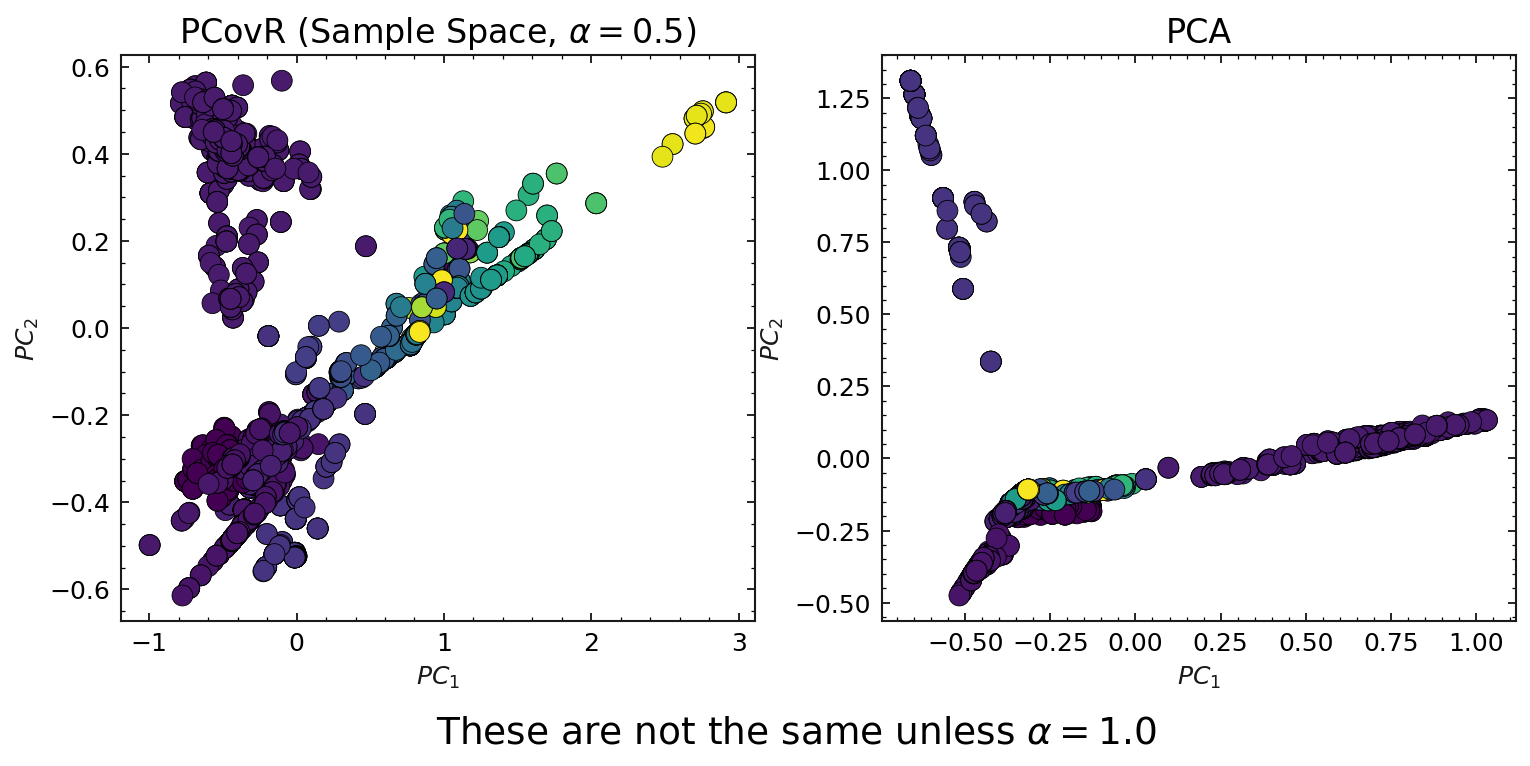

In [40]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref = PCA(n_components=n_PC)
ref.fit(X_train)
t_ref = ref.transform(X_test)

plot_projection(
    Y_test,
    check_mirrors(T_pcovr_test, t_ref),
    fig=fig,
    ax=axes[0],
    title=r"PCovR (Sample Space, $\alpha={}$)".format(alpha),
    **cmaps
)
plot_projection(Y_test, t_ref, fig=fig, ax=axes[1], title="PCA", **cmaps)

fig.suptitle(
    r"These are not the same unless $\alpha = 1.0.$",
    y=0.0,
    fontsize=plt.rcParams["font.size"] + 6,
)
plt.show()

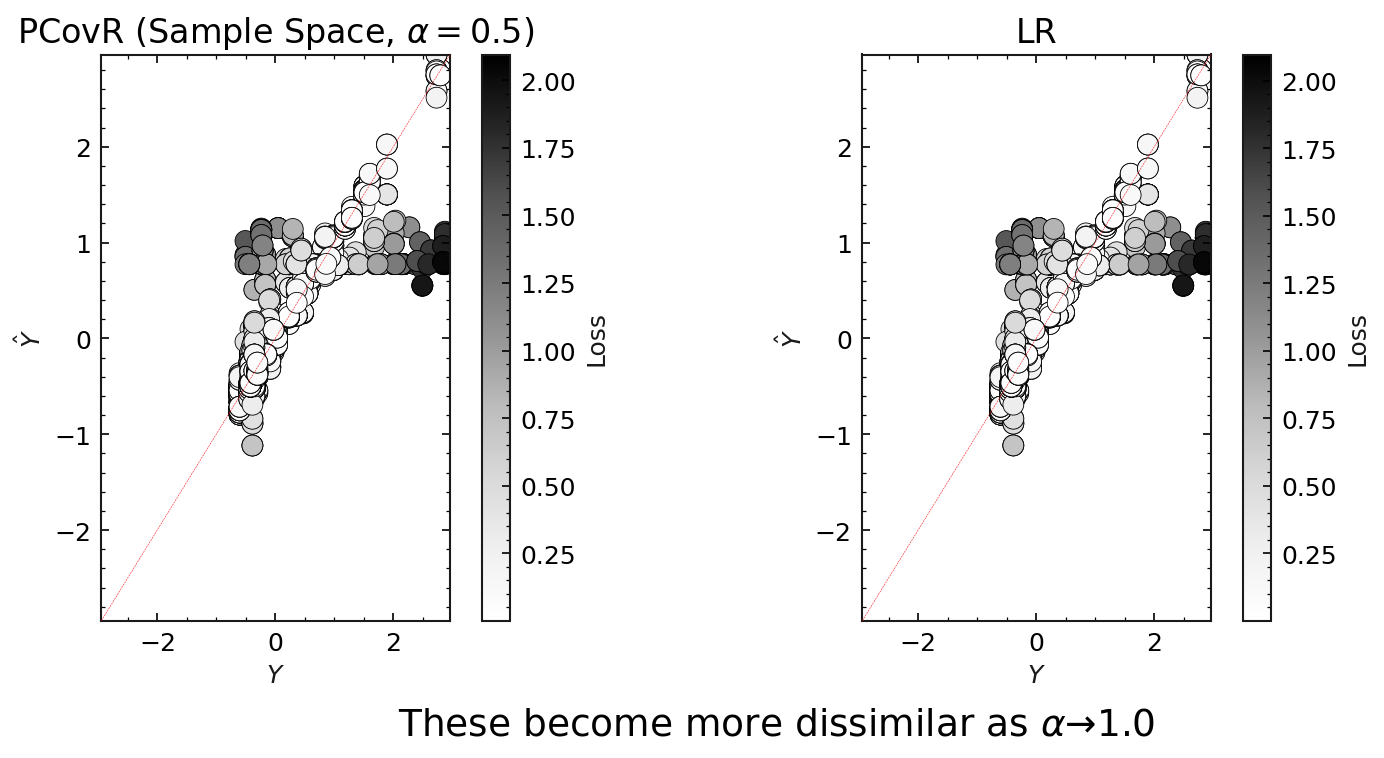

In [41]:
PTY = np.diagflat(1 / (v_Kt[:n_PC])) @ T.T @ Y_train
Y_pcovr_test = X_test @ PXT @ PTY

fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref_lr = Ridge(alpha=regularization)
ref_lr.fit(X_train, Y_train)
yref = lr.predict(X_test)

plot_regression(
    Y_test[:, 0],
    Y_pcovr_test[:, 0],
    fig=fig,
    ax=axes[0],
    title=r"PCovR (Sample Space, $\alpha={}$)".format(alpha),
    **cmaps
)
plot_regression(Y_test[:, 0], yref[:, 0], fig=fig, ax=axes[1], title="LR", **cmaps)

fig.suptitle(
    r"These become more dissimilar as $\alpha \to 1.0.$",
    y=0.01,
    fontsize=plt.rcParams["font.size"] + 6,
)
plt.show()


In [42]:
C = X_train.T @ X_train

PXV = PXT @ np.diagflat(1.0/np.sqrt(v_Kt[:n_PC]))

print(np.linalg.norm(PXV.T @ C @ PXV - 
                     np.eye(PXV.shape[1])))

4.7378604491347074e-08


In [43]:
v_C, U_C = np.linalg.eigh(C)

# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C = np.flip(U_C, axis=1)
v_C = np.flip(v_C, axis=0)

U_C = U_C[:,v_C>0]
v_C = v_C[v_C>0]

Csqrt = U_C @ np.diagflat(np.sqrt(v_C)) @ U_C.T
iCsqrt = U_C @ np.diagflat(1.0 / np.sqrt(v_C)) @ U_C.T

In [44]:
Ct = iCsqrt @ X_train.T
Ct = Ct @ K @ Ct.T

v_Ct, U_Ct = np.linalg.eigh(Ct)
U_Ct = np.flip(U_Ct, axis=1)
v_Ct = np.flip(v_Ct, axis=0)

U_Ct = U_Ct[:,v_Ct>0]
v_Ct = v_Ct[v_Ct>0]

In [46]:
PXV = iCsqrt @ U_Ct[:, :n_PC]

In [47]:
PXT = PXV @ np.diagflat(np.sqrt(v_Ct[:n_PC]))
PTX = np.diagflat(1.0 / np.sqrt(v_Ct[:n_PC])) @ U_Ct[:, :n_PC].T, Csqrt
PTY = (
    np.diagflat(1.0 / np.sqrt(v_Ct[:n_PC]))
    @ U_Ct[:, :n_PC].T
    @ iCsqrt
    @ X_train.T
    @ Y_train
)

In [49]:
T_fspcovr_test = X_test @ PXT

Y_fspcovr_test = T_fspcovr_test @ PTY

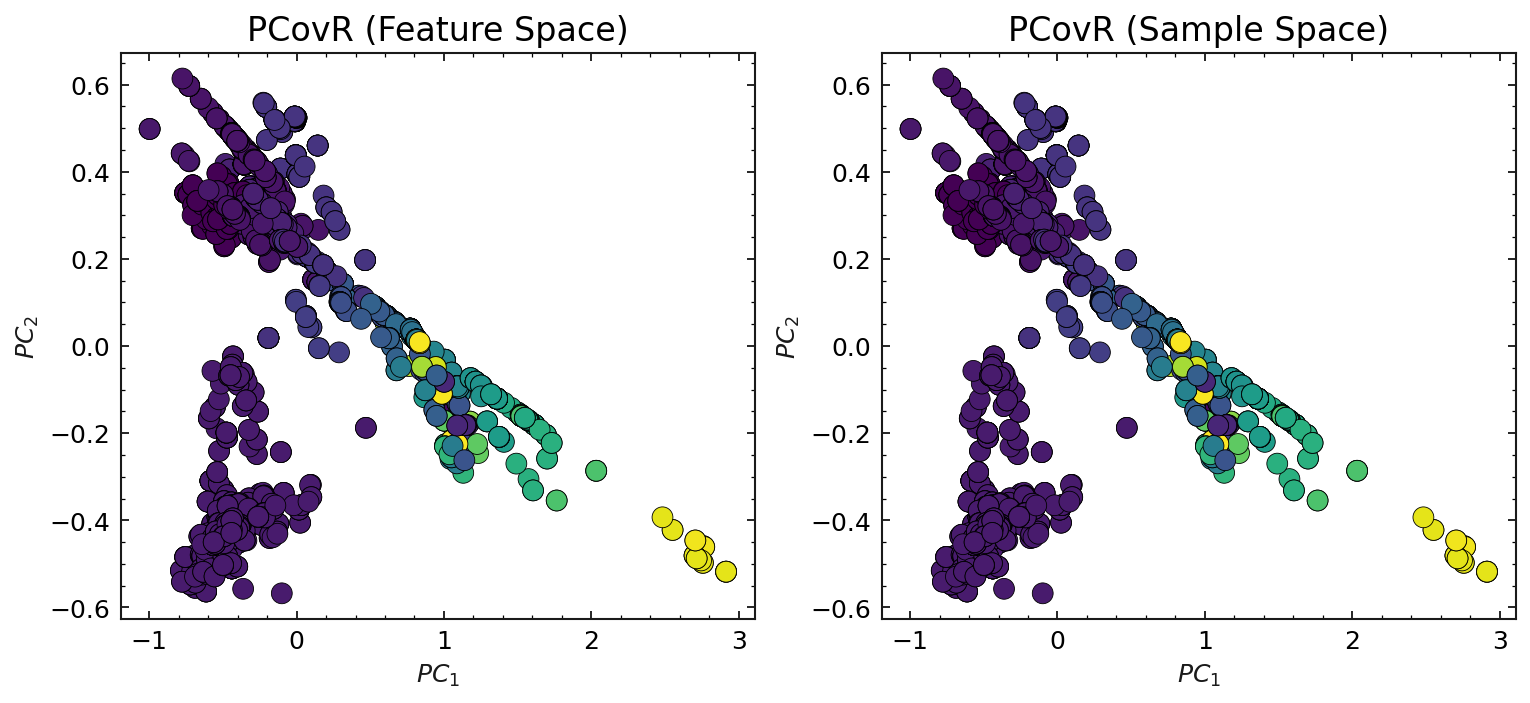

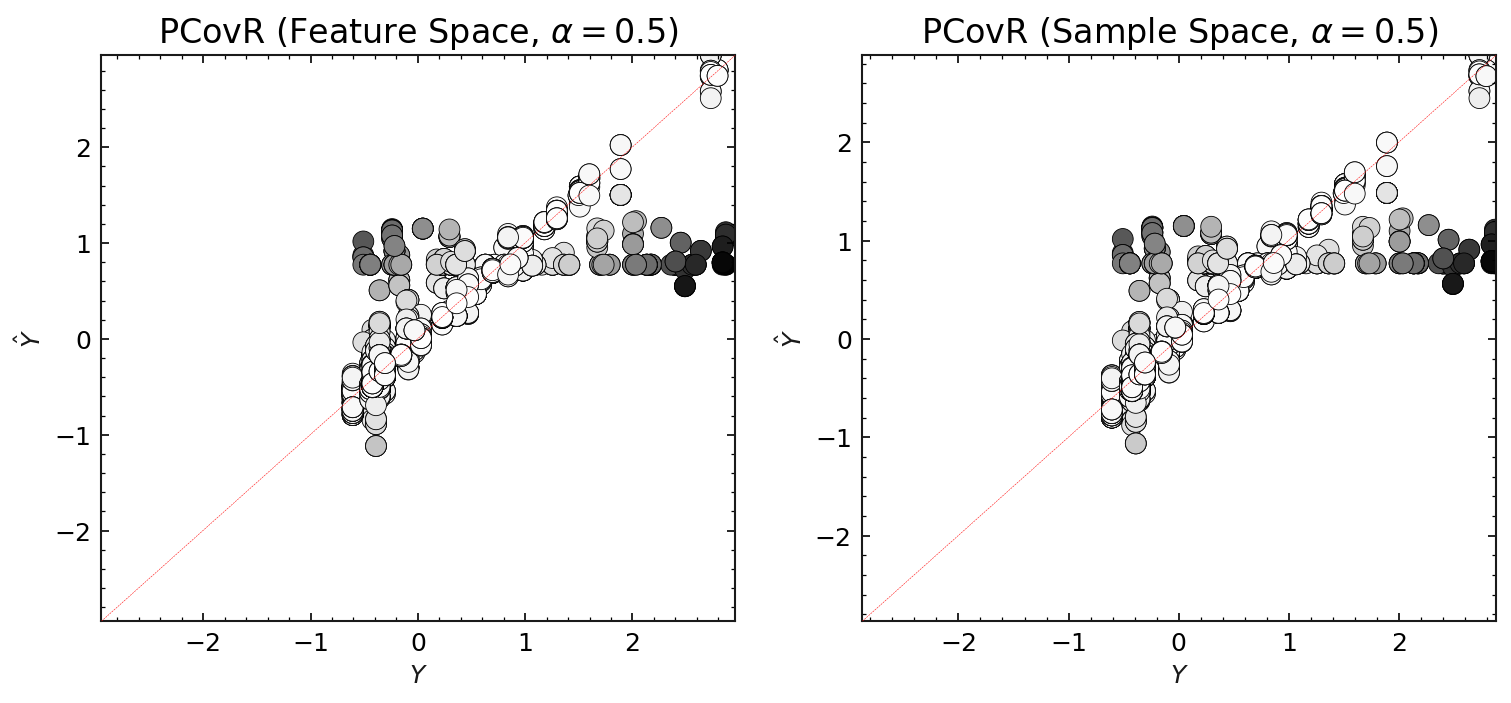

In [50]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref = PCovR(mixing=alpha, n_components=2, space="sample")
ref.fit(X_train, Y_train)
tref = ref.transform(X_test)
yref = ref.predict(X_test)
xref = ref.inverse_transform(tref)

plot_projection(
    Y_test,
    check_mirrors(T_fspcovr_test, tref),
    fig=fig,
    ax=axes[0],
    title="PCovR (Feature Space)",
    **cmaps
)
plot_projection(
    Y_test, tref, fig=fig, ax=axes[1], title="PCovR (Sample Space)", **cmaps
)

fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

plot_regression(
    Y_test[:, 0],
    Y_fspcovr_test[:, 0],
    fig=fig,
    ax=axes[0],
    title=r"PCovR (Feature Space, $\alpha={}$)".format(alpha),
    cbar=False,
    **cmaps
)
plot_regression(
    Y_test[:, 0],
    yref[:, 0],
    fig=fig,
    ax=axes[1],
    title=r"PCovR (Sample Space, $\alpha={}$)".format(alpha),
    cbar=False,
    **cmaps
)

plt.show()

In [52]:


n_alphas = 11
alphas = np.linspace(0.0, 1.0, n_alphas)
components = np.arange(0, 5, 1, dtype=int)[2::]
n_components = components.size

pcovr_calculators = np.array(
    [
        [PCovR(mixing=a, n_components=c, space="feature") for a in alphas]
        for c in components
    ]
)

for cdx, c in enumerate(components):
    for adx, a in enumerate(alphas):
        pcovr_calculators[cdx][adx].fit(X_train, Y_train)



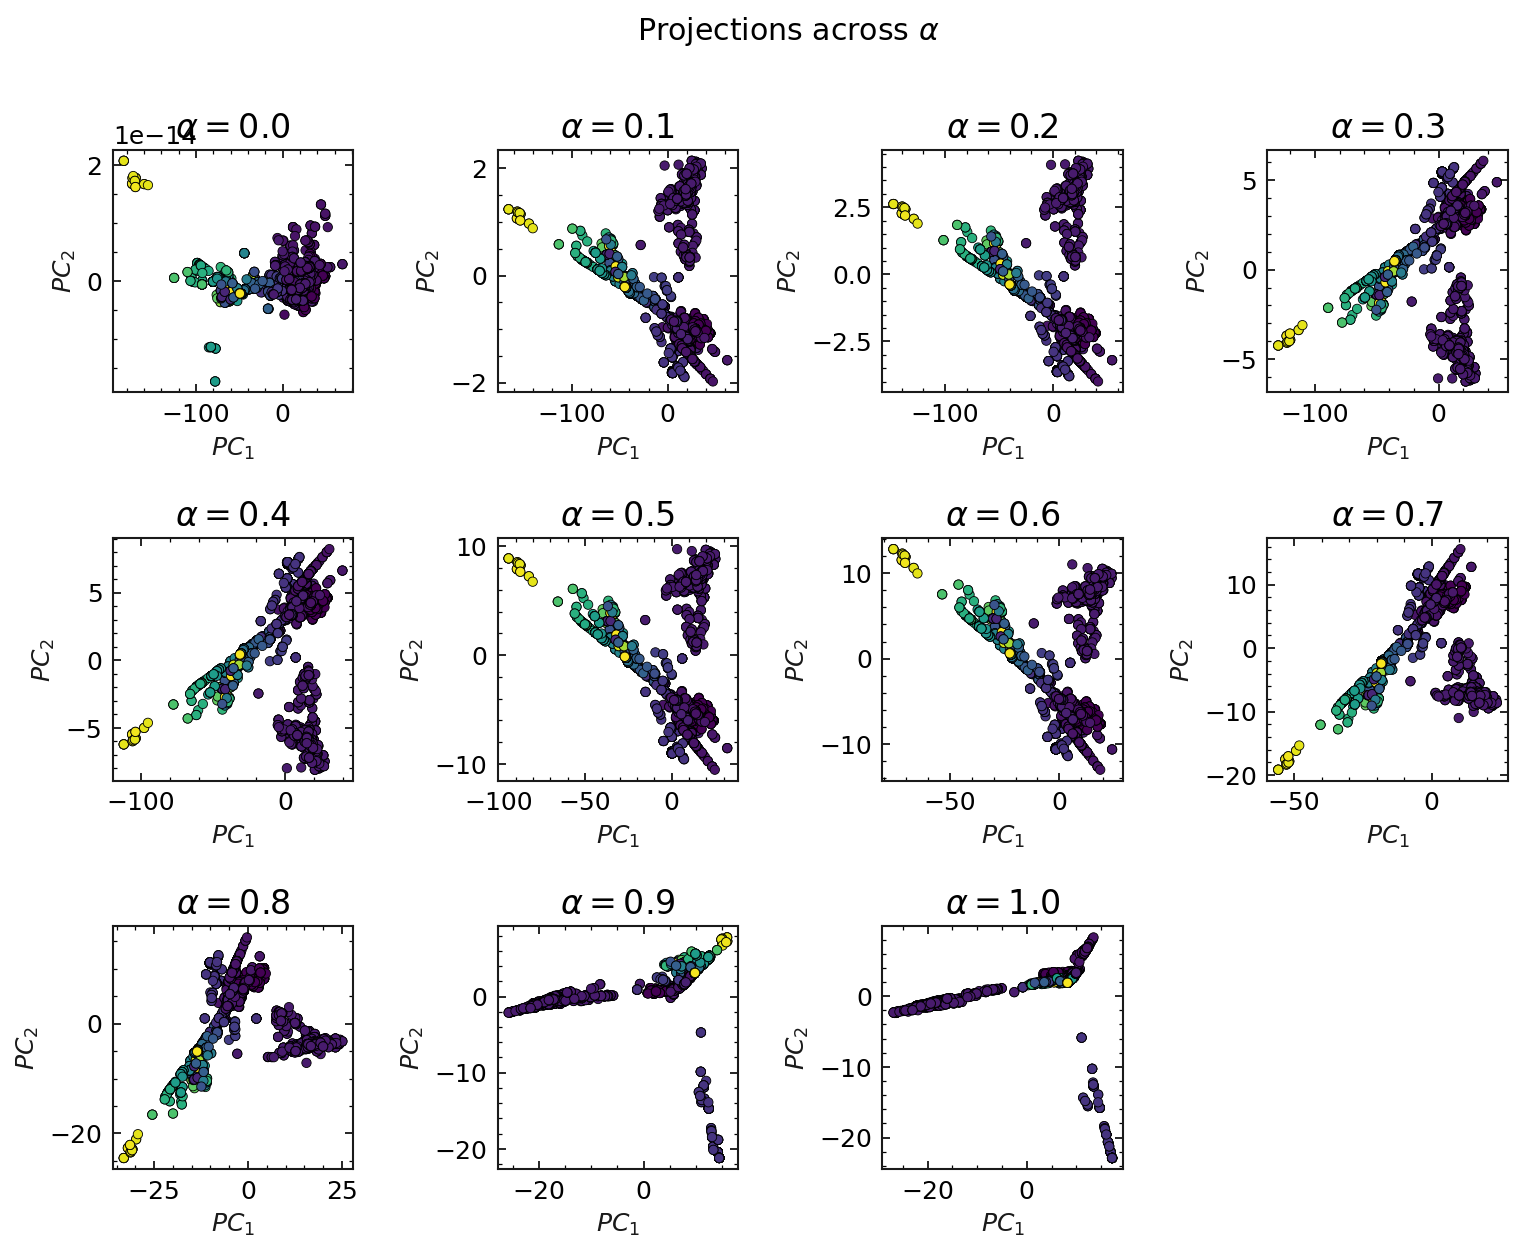

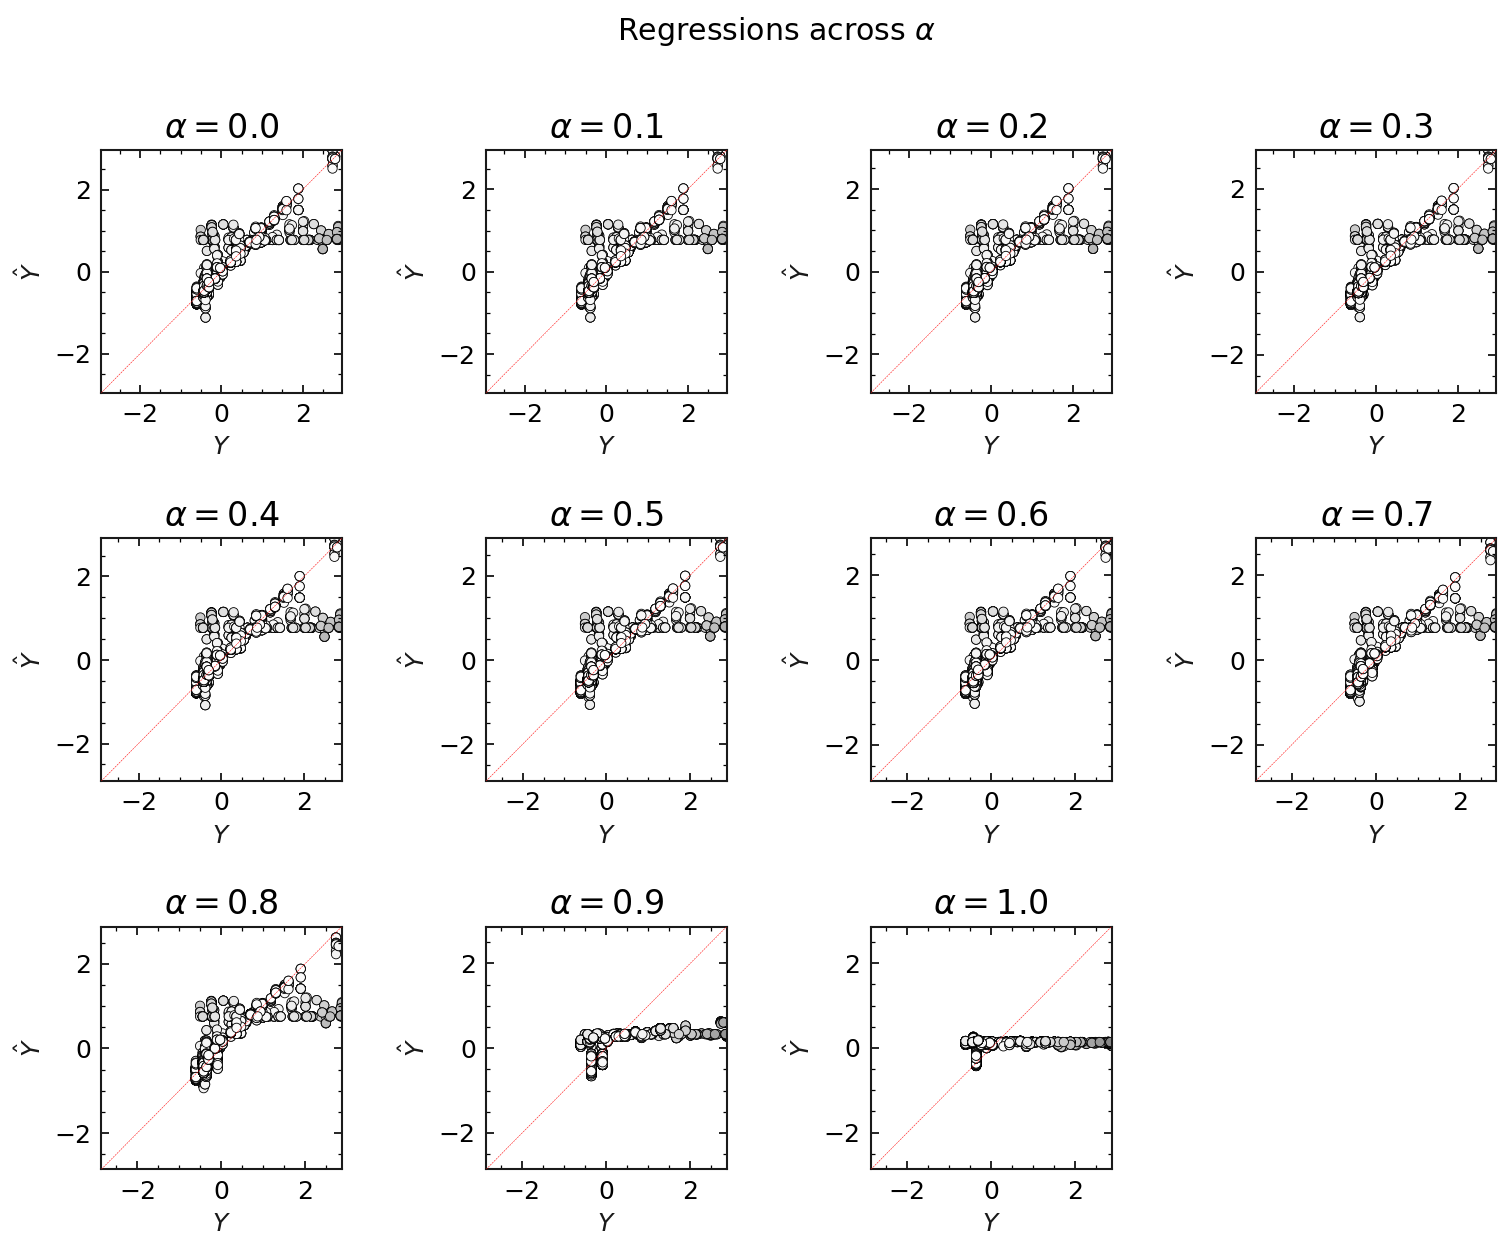

In [53]:
n_plots = int(n_alphas ** 0.5)
scale = 3

t_ref = pcovr_calculators[0][-3].transform(X_test)
y_ref = pcovr_calculators[0][-3].predict(X_test)
x_ref = pcovr_calculators[0][-3].inverse_transform(tref)

pfig, pax = plt.subplots(
    n_plots,
    int(np.ceil(n_alphas / n_plots)),
    figsize=(
        scale * int(np.ceil(n_alphas / n_plots)),
        scale * n_plots,
    ),
)

rfig, rax = plt.subplots(
    n_plots,
    int(np.ceil(n_alphas / n_plots)),
    figsize=(
        scale * int(np.ceil(n_alphas / n_plots)),
        scale * n_plots,
    ),
)
for p, r, pcovr in zip(pax.flatten(), rax.flatten(), pcovr_calculators[0]):

    t = pcovr.transform(X_test)
    y = pcovr.predict(X_test)
    x = pcovr.inverse_transform(t)

    plot_projection(
        Y_test, check_mirrors(t, t_ref), fig=pfig, ax=p, alpha=1.0, s=20, **cmaps
    )

    plot_regression(
        Y_test[:, 0],
        y[:, 0],
        fig=pfig,
        ax=r,
        cbar=False,
        vmin=0,
        vmax=5,
        alpha=1.0,
        s=20,
        **cmaps,
    )

    p.set_title(r"$\alpha=$" + str(round(pcovr.mixing, 3)))
    r.set_title(r"$\alpha=$" + str(round(pcovr.mixing, 3)))


for p, r in zip(pax.flatten()[n_alphas:], rax.flatten()[n_alphas:]):
    p.axis("off")
    r.axis("off")

pfig.subplots_adjust(wspace=0.6, hspace=0.6)
pfig.suptitle(r"Projections across $\alpha$")
rfig.subplots_adjust(wspace=0.6, hspace=0.6)
rfig.suptitle(r"Regressions across $\alpha$")

plt.show()


In [54]:
L_pca = np.zeros((n_components, n_alphas))
L_lr = np.zeros((n_components, n_alphas))

for cdx, c in enumerate(components):
    for adx, a in enumerate(alphas):
        calculator = pcovr_calculators[cdx][adx]
        
        # TODO: remove except when score is merged into skcosmo
        try:
            L_pca[cdx, adx], L_lr[cdx, adx] = calculator.score(X_test, Y_test)
        except:
            xr = calculator.inverse_transform(calculator.transform(X_test))
            yp = calculator.predict(X_test)

            L_pca[cdx, adx] = (
                np.linalg.norm(X_test - xr) ** 2.0 / np.linalg.norm(X_test) ** 2.0
            )
            L_lr[cdx, adx] = (
                np.linalg.norm(Y_test - yp) ** 2.0 / np.linalg.norm(Y_test) ** 2.0
            )

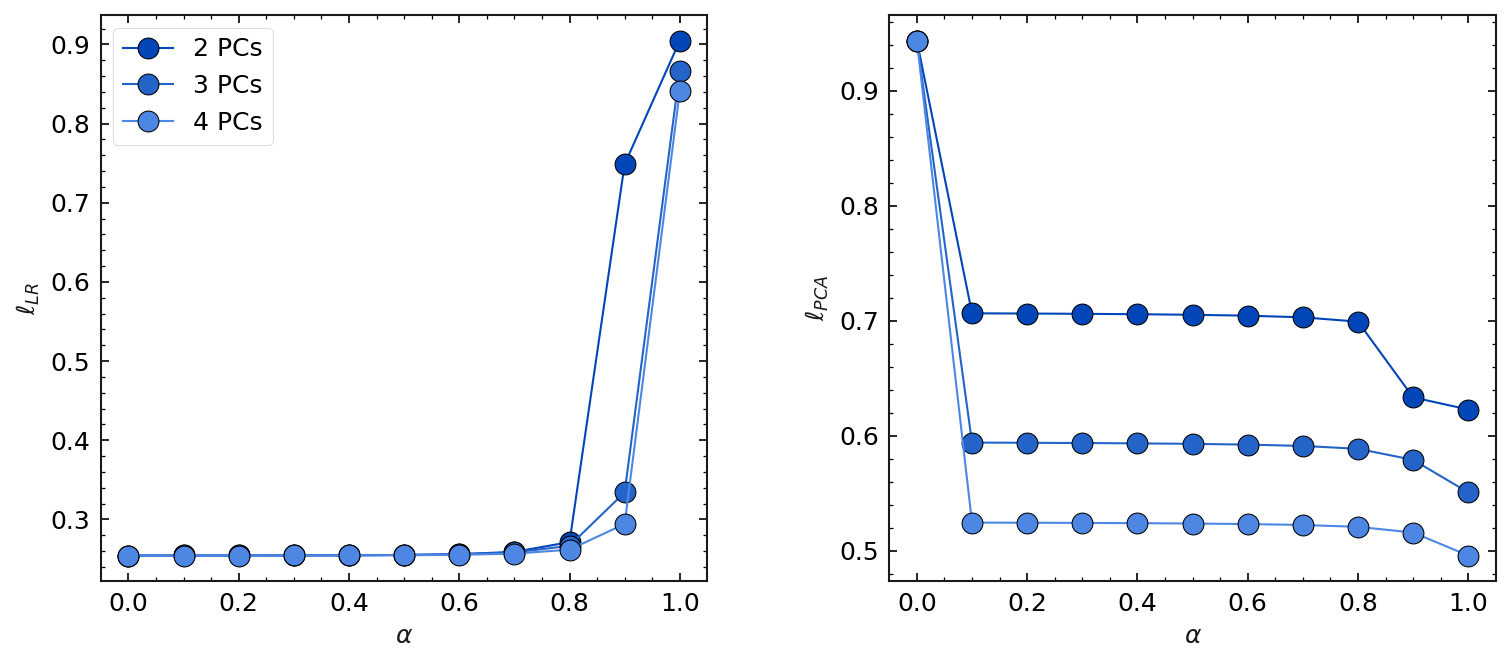

In [55]:
fig, [axsLR, axsPCA] = plt.subplots(1, 2, figsize=dbl_fig, sharex=True)

for cdx, c in enumerate(components):
    axsLR.plot(alphas, L_lr[cdx, :], marker="o", label="{:d} PCs".format(c))
    axsPCA.plot(alphas, L_pca[cdx, :], marker="o", label="{:d} PCs".format(c))

axsLR.set_ylabel(r"$\ell_{LR}$")
axsLR.set_xlabel(r"$\alpha$")
axsPCA.set_ylabel(r"$\ell_{PCA}$")
axsPCA.set_xlabel(r"$\alpha$")

fig.subplots_adjust(wspace=0.3)
axsLR.legend()
plt.show()

Optimal alpha for 2 PCs = 0.50
Optimal alpha for 3 PCs = 0.50
Optimal alpha for 4 PCs = 0.50


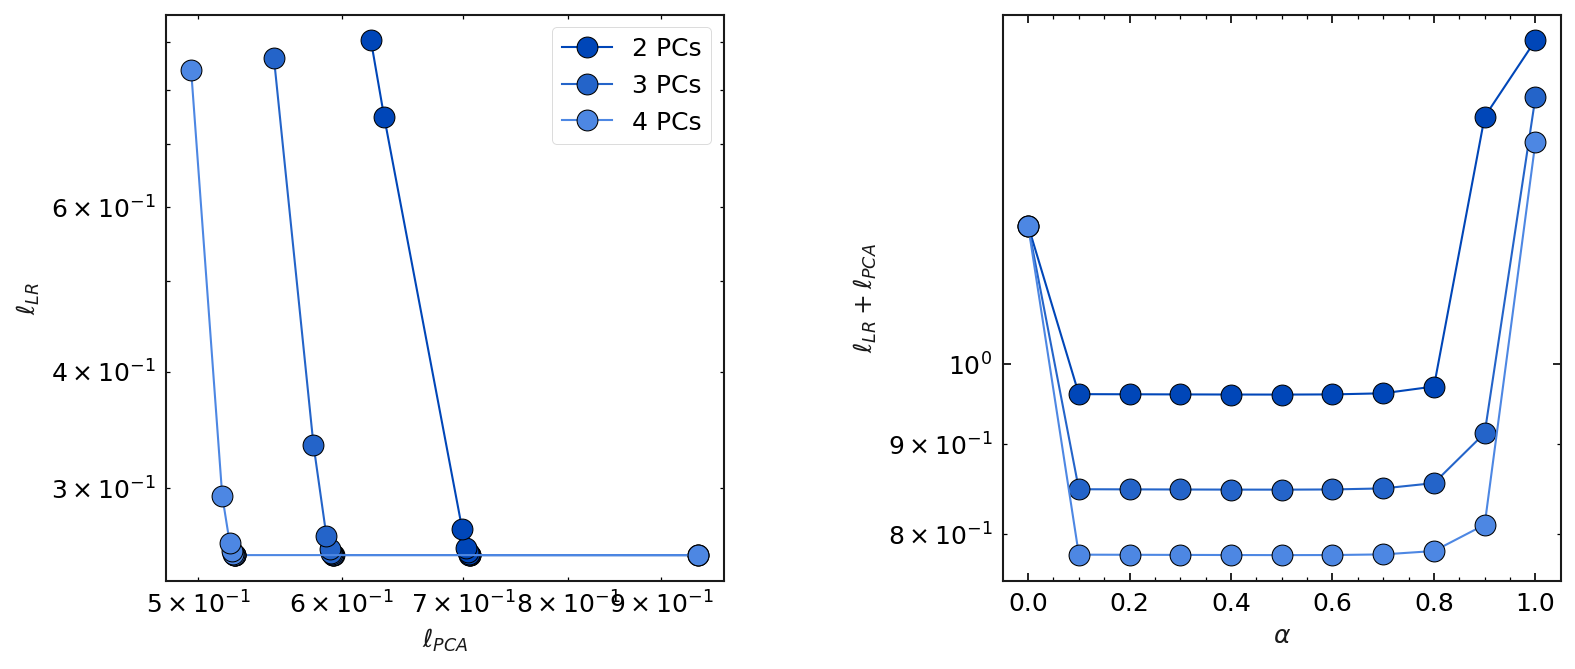

In [56]:
fig = plt.figure(figsize=dbl_fig)
axsLoss = fig.add_subplot(1, 2, 1)
axsSum = fig.add_subplot(1, 2, 2)

for cdx, c in enumerate(components):
    axsLoss.loglog(L_pca[cdx, :], L_lr[cdx, :], marker="o", label="{:d} PCs".format(c))

axsLoss.set_xlabel(r"$\ell_{PCA}$")
axsLoss.set_ylabel(r"$\ell_{LR}$")
axsLoss.legend()

for cdx, c in enumerate(components):
    loss_sum = L_lr[cdx, :] + L_pca[cdx, :]
    axsSum.semilogy(alphas, loss_sum, marker="o", label="{:d} PCs".format(c))
    print("Optimal alpha for {:d} PCs = {:.2f}".format(c, alphas[np.argmin(loss_sum)]))

axsSum.set_xlabel(r"$\alpha$")
axsSum.set_ylabel(r"$\ell_{LR} + \ell_{PCA}$")

fig.subplots_adjust(wspace=0.5, hspace=0.3)

plt.show()

In [32]:
"""Initializing StandarScaler and fitting the X_raw SOAP 2D matrix so that the standard 
normal distribution of the features has a mean of zero and a standard deviation of one """

scaler=StandardScaler()
scaler.fit(C) 
X_scaled=scaler.transform(C)
n_components = 2

# """Normal PCA, takes more memory"""

# pca=PCA(n_components=n_components) 
# pca.fit(X_scaled)
# X_pca = pca.fit_transform(X_scaled)

"""Incremental PCA, change batch size freely"""

ipca = IncrementalPCA(n_components=n_components, batch_size=20)
# ipca.fit(X_scaled)
X_ipca = ipca.fit_transform(X_scaled)

In [23]:
# natoms=(list(natoms(qb_red)))
def magic(l):
    cdict={}
    for i in range(len(l)): 
        if l[i]%4==0:
            c='r'
        else:
            c='b'
        cdict['natoms='+str(l[i])]=c
    return cdict


cdict={magic}
properties = {
    "PC1": {
        "target": "atom",
        "values": X_ipca[:,0],
    },
    "PC2": {
        "target": "atom",
        "values": X_ipca[:,1],
    },
    "atomic_species": {
        "target": "atom",
        "values": np.concatenate([frame.numbers for frame in frames_ase])
    },
}

write_input("chem_mixed.json.gz", frames=frames_ase)

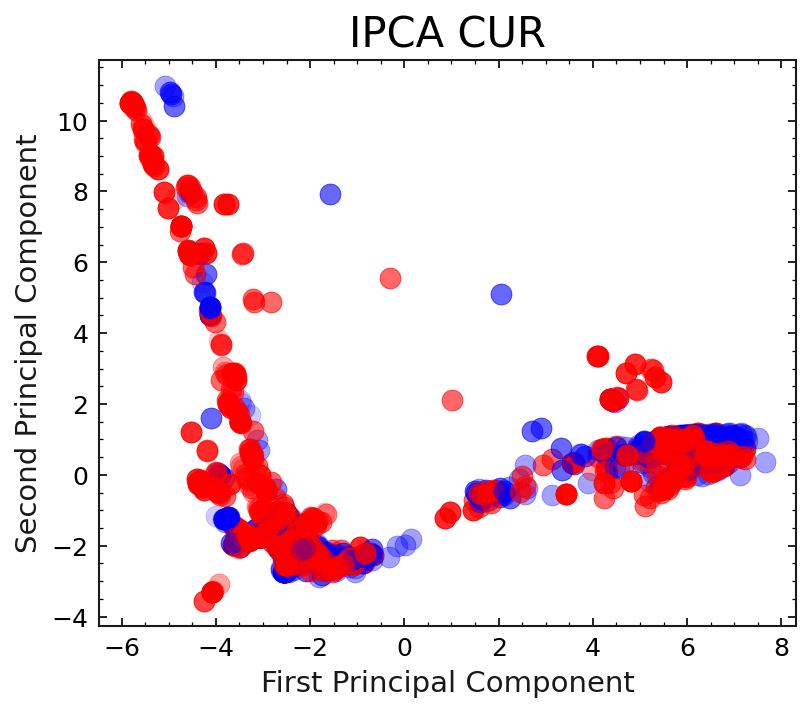

In [54]:
fig,ax=plt.subplots(figsize=(6,5))
start=0
for frame in frames_ase:
    natoms=(len(frame))
#     print(start, natoms)
    if natoms%4==0:
        ax.scatter(X_ipca[start:int(start+natoms), 0], X_ipca[start:int(start+natoms), 1],c='r', alpha=0.2)
    else:
        ax.scatter(X_ipca[start:int(start+natoms) , 0], X_ipca[start:int(start+natoms), 1], c='b', alpha=0.2)
    start=start+natoms
        # plt.savefig('PCA_2.png', bbox_inches= 'tight', dpi=400 )

plt.title("IPCA CUR",fontsize=20)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.savefig('IPCA_mixed_db', bbox_inches= 'tight', dpi=700 )
plt.show()
plt.close()